<h1>Black-Litterman Model</h1>

<h2>Introduction</h2>

The BL model is an asset allocation framework that produces a set of expected asset returns that are a blend of two components:<br>
<ol>
<li><b>Market Equilibrium Return</b> ($\Pi$): The returns implied by the current market capitalization weight. These are the prior estimates.</li>
<li><b>Investors View</b> ($Q$): Investors' specific forecasts about the return of certain assets. This acts as the <b>Information</b> or <b>View</b>.</li>
</ol>

The output is a new, refined set of **Posterior Expected Returns** ($E$) the can be plugged into a standard Mean-Variance Optimization framework to find the optimal portfolio weights.

<h3>1. Market Equilibrium Return ($\Pi$)</h3>

This is the starting point. It assumes all assets are priced efficiently according to the **Capital Asset Pricing Model (CAPM)**.

$$
\Pi = \lambda \Sigma w_{mkt}
$$

where:<br>
$\Pi$ is the Vector of implied Equilibrium Excess Returns (The Prior).<br>
$\Sigma$ is the covariance matrix of the asset returns.<br>
$w_{mkt}$ is the vector of market capitalization weights.<br>
$\lambda $ is the risk aversion parameter.

The $\lambda$ is often computed by as $$\lambda = (E(R_{m})-R_{f})/\sigma_{m}^2$$

where:<br>
$E(R_m)$ is the expected market return,
$R_f$ is the risk-free rate, and
$\sigma_m^2$ is the market variance.

For this project, I'm using pythons' library for *portfolio optimization and allocation*, **PyPortfolioOpt**.

In [1]:
#importing libraries
import numpy as np
import pandas as pd

import yfinance as yf
from fredapi import Fred

import os
from dotenv import load_dotenv

import matplotlib.pyplot as plt

from pypfopt import expected_returns, risk_models, black_litterman, efficient_frontier

import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)

I'm using these tickers (assests) for this project:
<ul>
<li><b>AAPL:</b> Apple</li>
<li><b>NVDA:</b> Nvidia</li>
<li><b>JPM:</b> JPMoraga & chase</li>
<li><b>AMZN:</b> Amazon</li>
<li><b>GOOGL:</b> Google</li>
<li><b>PG:</b> Procter & Gamble</li>
<li><b>XOM:</b> Exxon Mobil Corp</li>
<li><b>JNJ:</b> Johnson & Johnson</li>
<li><b>^GSPC:</b>  S&P500 Index </li>
</ul>

From **01/01/2020** to **30/10/2025**, approximatly *six year of data*.

In [2]:
#fetching data
tickers = ['AAPL', 'NVDA', 'JPM', 'AMZN', 'GOOGL', 'PG', 'XOM', 'JNJ', '^GSPC']
start = '2020-01-01'
end = '2025-10-30'

In [3]:
df = yf.download(tickers, start, end)['Close']
df.head()

[*********************100%***********************]  9 of 9 completed


Ticker,AAPL,AMZN,GOOGL,JNJ,JPM,NVDA,PG,XOM,^GSPC
Date,,,,,,,,,
2020-01-02,72.468269,94.900497,67.920799,123.290184,119.573334,5.971077,106.273239,53.661724,3257.850098
2020-01-03,71.763741,93.748497,67.565483,121.862747,117.995445,5.875505,105.558495,53.230297,3234.850098
2020-01-06,72.335571,95.143997,69.366386,121.710739,117.901619,5.900145,105.704895,53.639019,3246.280029
2020-01-07,71.995346,95.343002,69.232407,122.454041,115.897179,5.971575,105.050415,53.200024,3237.179932
2020-01-08,73.153473,94.598503,69.725174,122.437103,116.801300,5.982775,105.498238,52.397739,3253.050049


In [4]:
print(df.shape)
df.info()

(1465, 9)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1465 entries, 2020-01-02 to 2025-10-29
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    1465 non-null   float64
 1   AMZN    1465 non-null   float64
 2   GOOGL   1465 non-null   float64
 3   JNJ     1465 non-null   float64
 4   JPM     1465 non-null   float64
 5   NVDA    1465 non-null   float64
 6   PG      1465 non-null   float64
 7   XOM     1465 non-null   float64
 8   ^GSPC   1465 non-null   float64
dtypes: float64(9)
memory usage: 114.5 KB


For the risk-free rate, I'm using the *3 Months T-Bills* data for the same time period as the assests' data.

In [5]:
#using fred api to get the T-Bill data
load_dotenv()
fred_key = os.environ.get("FRED_API_KEY")
fred = Fred(fred_key)

In [6]:
tbill = fred.get_series(series_id='DGS3MO', observation_start=start, observation_end=end)

In [7]:
tbill  = tbill.to_frame().ffill() #using fill-forward method to compensate for the missing values in tbill data.
tbill.head()

,0
2020-01-01,NaN
2020-01-02,1.54
2020-01-03,1.52
2020-01-06,1.56
2020-01-07,1.54


Now, I'll create a function to align all the data with respect to the dates in the index. The function takes the assets dataframe and tbill dataframe. It joins the data in accordance with the data. It also drops a particular observation if any of the variables in missing. The output of this function is **assets_prices** (*pandas' dataframe*), **market_prices** (*pandas' series*), and **rate** (*pandas' series*).

In [8]:
def data_align(df, tbill):
    tbill.columns = ['RFR']
    df = df.join(tbill, how='inner')
    asset_prices = df.iloc[:, :-2]
    market_prices = df.iloc[:, -2]
    rate = df.iloc[:, -1]
    return asset_prices, market_prices, rate

In [9]:
asset_prices, market_prices, rate = data_align(df, tbill)

In [10]:
asset_prices.head()

,AAPL,AMZN,GOOGL,JNJ,JPM,NVDA,PG,XOM
2020-01-02,72.468269,94.900497,67.920799,123.290184,119.573334,5.971077,106.273239,53.661724
2020-01-03,71.763741,93.748497,67.565483,121.862747,117.995445,5.875505,105.558495,53.230297
2020-01-06,72.335571,95.143997,69.366386,121.710739,117.901619,5.900145,105.704895,53.639019
2020-01-07,71.995346,95.343002,69.232407,122.454041,115.897179,5.971575,105.050415,53.200024
2020-01-08,73.153473,94.598503,69.725174,122.437103,116.801300,5.982775,105.498238,52.397739


In [11]:
market_prices.head()

2020-01-02    3257.850098
2020-01-03    3234.850098
2020-01-06    3246.280029
2020-01-07    3237.179932
2020-01-08    3253.050049
Name: ^GSPC, dtype: float64

In [12]:
rate.head()

2020-01-02    1.54
2020-01-03    1.52
2020-01-06    1.56
2020-01-07    1.54
2020-01-08    1.54
Name: RFR, dtype: float64

The PyPortfolioOpt takes a single float number as an input for the risk-free-rate. So now I use the rate data series to compute the single risk-free rate, and it'll be *averaged decimal number* of rate.

In [13]:
risk_free_rate = (rate/100).mean()
risk_free_rate

np.float64(0.02827037542662116)

This is our **risk-free-rate**.

Now I compute $\lambda$

In [14]:
delta = black_litterman.market_implied_risk_aversion(market_prices=market_prices, risk_free_rate=risk_free_rate)
delta

np.float64(2.7566914335000696)

$\Sigma$

In [15]:
sigma = risk_models.sample_cov(asset_prices)
sigma

,AAPL,AMZN,GOOGL,JNJ,JPM,NVDA,PG,XOM
AAPL,0.103642,0.068495,0.065867,0.020857,0.043299,0.100617,0.026791,0.031286
AMZN,0.068495,0.127590,0.074182,0.009308,0.034152,0.111678,0.015144,0.017767
GOOGL,0.065867,0.074182,0.105724,0.015356,0.041949,0.101357,0.019075,0.027305
JNJ,0.020857,0.009308,0.015356,0.038916,0.022984,0.009590,0.024429,0.018757
JPM,0.043299,0.034152,0.041949,0.022984,0.099813,0.058370,0.022580,0.058179
NVDA,0.100617,0.111678,0.101357,0.009590,0.058370,0.287221,0.020226,0.032432
PG,0.026791,0.015144,0.019075,0.024429,0.022580,0.020226,0.042732,0.015275
XOM,0.031286,0.017767,0.027305,0.018757,0.058179,0.032432,0.015275,0.109865


In [16]:
#fetching market caps for each asset
mcap = {}
for i in tickers[0:-1]:
    stock = yf.Ticker(i)
    mcap[i] = stock.fast_info["market_cap"]

mcap

{'AAPL': 4137203906084.2896,
 'NVDA': 4474491630279.541,
 'JPM': 852726127384.3425,
 'AMZN': 2477778253980.0,
 'GOOGL': 3878422576264.601,
 'PG': 327246666475.06604,
 'XOM': 509628552912.9992,
 'JNJ': 497615794191.3927}

In [17]:
#computing prior/Pi
prior = black_litterman.market_implied_prior_returns(market_caps=mcap, risk_aversion=delta, cov_matrix=sigma, risk_free_rate=risk_free_rate)

In [18]:
hist_excess_ret = prior*100
print("Market Implied Excess Returns in Percentage:\n", hist_excess_ret)

Market Implied Excess Returns in Percentage:
 AAPL     24.941308
AMZN     25.881450
GOOGL    25.057846
JNJ       7.138932
JPM      16.023475
NVDA     42.179773
PG        8.708760
XOM      11.575246
dtype: float64


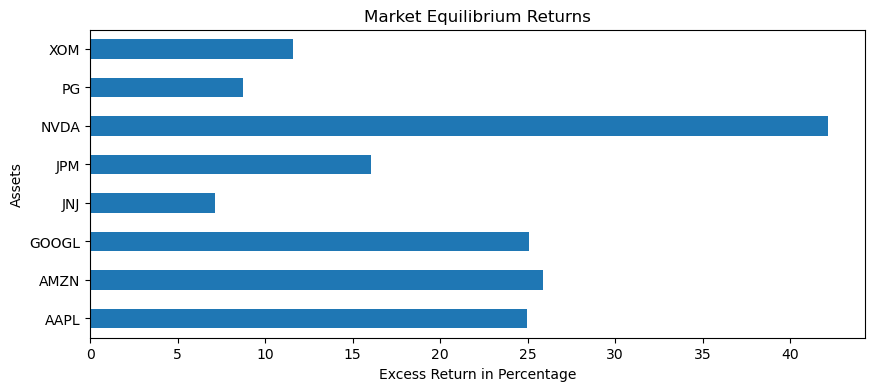

In [19]:
plt.figure(figsize=(10,4))
hist_excess_ret.plot.barh()
plt.title('Market Equilibrium Returns')
plt.xlabel("Excess Return in Percentage")
plt.ylabel("Assets")

plt.savefig("Market Equilibrium Returns.jpg");

<h3>Investors View</h3>

The beauty of Black-Litterman Model is that, as an investor we can incorporate our views about the performance of the assets, in the model.

Mathematically, Views are expressed as:<br>
$$
P.\mu = Q + \epsilon
$$

where:<br>
$P$ is the picking matrix that links views to assets<br>
$\mu$ is the vector of expected returns, which we're solving<br>
$Q$ is the vector of views return<br>
$\epsilon$ is the error term ~ N(0, $\Omega$)

There are two types of views:<br>
<ul>
<li><b>Absolute View</b>: The view related to single asset.</li>
<li><b>Relative View</b>: The view related to two or more assets.</li>
</ul>

In [20]:
tickers[0:-1]

['AAPL', 'NVDA', 'JPM', 'AMZN', 'GOOGL', 'PG', 'XOM', 'JNJ']

I'm assuming some hypothetical performances. To cover the whole topic, I'm selecting the *views for both* Absolute view and Relative view.<br>
My views are:<br>
<ul>
<li><b>NVDA will perform 5% better than equilibrium.</b> <i>(Absolute view)</i></li>
<li><b>PG will downperform 2% by equilibrium.</b> <i>(Absolute view)</i></li>
<li><b>AMZN will perform better by 3% with respect to XOM.</b> <i>(Relative view)</i></li>
<li><b>JPM will perform better by 2% with respect to JNJ.</b> <i>(Relative view)</i></li>
</ul>

In [21]:
P = np.array([
    [0, 1, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 0, 0],
    [0, 0, 0, 1, 0, 0, -1, 0],
    [0, 0, 1, 0, 0, 0, 0, -1],
])

In [22]:
Q = np.array(
    [(prior['NVDA']+0.05),
     (prior['PG']-0.02),
     3/100,
     2/100]
).reshape(-1,1)

In [23]:
Q

array([[0.47179773],
       [0.0670876 ],
       [0.03      ],
       [0.02      ]])

<h4>The confidence Matrix ($\Omega$)</h4>

We have to tell the model how confident we're about our views. **$\Omega$** represents how confident we are in each view.

$$
\Omega = diag(\tau P \Sigma P^T)
$$

or more commonly simplified to:
$$
\Omega = diag(1/confidence)
$$

where:<br>
**$\tau$** is a scaling factor. It basically means how certain I believe the market is. I've selected $\tau = 0.1$.<br> Higher Confidence = Smaller $\Omega$ values. I'm using the *PyPortfolioOpt's* **default_omega** function.

In [24]:
omega = black_litterman.BlackLittermanModel.default_omega(cov_matrix=sigma, P=P, tau=0.1)

In [25]:
omega

array([[0.01275901, 0.        , 0.        , 0.        ],
       [0.        , 0.02872213, 0.        , 0.        ],
       [0.        , 0.        , 0.00327903, 0.        ],
       [0.        , 0.        , 0.        , 0.01609798]])

The Black-Litterman model combines equilibrium and views using Bayesian updating:<br>
$$
\mu_{BL} = [(\tau \Sigma)^{-1} + P^T \Omega^{-1} P]^{-1} [(\tau \Sigma)^{-1} \Pi + P^T \Omega^{-1}Q]
$$

After rearranging, the formula becomes:<br>
$$
\mu_{BL} = \Pi + \tau \Sigma P^T [P\tau \Sigma P^T + \Omega]^{-1} (Q-P\Pi)
$$

In [26]:
posterior = black_litterman.BlackLittermanModel(cov_matrix=sigma, pi=prior, Q=Q, P=P, omega=omega, tau=0.1, risk_aversion=delta)

In [27]:
mu = posterior.bl_returns()
mu

AAPL     0.238953
AMZN     0.307112
GOOGL    0.230940
JNJ      0.086217
JPM      0.163757
NVDA     0.299504
PG       0.077105
XOM      0.147299
dtype: float64

In [28]:
new_sigma = posterior.bl_cov()
new_sigma

,AAPL,AMZN,GOOGL,JNJ,JPM,NVDA,PG,XOM
AAPL,0.111145,0.071058,0.069288,0.022713,0.046257,0.104352,0.028801,0.034010
AMZN,0.071058,0.133191,0.076727,0.009798,0.035613,0.114533,0.015716,0.019081
GOOGL,0.069288,0.076727,0.112203,0.016657,0.045087,0.104677,0.020377,0.030824
JNJ,0.022713,0.009798,0.016657,0.042426,0.025028,0.010028,0.027201,0.020308
JPM,0.046257,0.035613,0.045087,0.025028,0.108729,0.060969,0.024555,0.062755
NVDA,0.104352,0.114533,0.104677,0.010028,0.060969,0.300031,0.020866,0.034496
PG,0.028801,0.015716,0.020377,0.027201,0.024555,0.020866,0.046397,0.016688
XOM,0.034010,0.019081,0.030824,0.020308,0.062755,0.034496,0.016688,0.118035


Now that I've Black-Litterman returns and covariance, I'll use *Markowitz Optimization* to to get portfolio weights.

In [29]:
ef = efficient_frontier.EfficientFrontier(expected_returns=mu, cov_matrix=new_sigma, weight_bounds=(0, 0.25))
ef.max_sharpe()

OrderedDict([('AAPL', 0.1788011796487328),
             ('AMZN', 0.25),
             ('GOOGL', 0.1426347531190726),
             ('JNJ', 0.25),
             ('JPM', 0.0321822931099061),
             ('NVDA', 0.0124649122969853),
             ('PG', 0.0),
             ('XOM', 0.133916861825303)])

*Max Sharpe Ratio* Portfolio is a tangency portfolio. It gives us the best **risk-adjusted** portfolio. It doesn't care about our personal risk preferences.<br>
That's why I'm using **Max Utility** Portfolio. It balances our return against risk based on our personal risk aversion ($\lambda$).<br>
The goal is:<br>
$$
max_{w} = [w^T \mu_{BL} - \lambda/2 w^T \Sigma w]
$$

In [30]:
ef1 = efficient_frontier.EfficientFrontier(cov_matrix=new_sigma, expected_returns=mu, weight_bounds=(0, 0.20))
ef1.max_quadratic_utility(risk_aversion=delta)
weights = ef1.clean_weights()
weights

OrderedDict([('AAPL', 0.2),
             ('AMZN', 0.2),
             ('GOOGL', 0.2),
             ('JNJ', 0.12365),
             ('JPM', 0.05657),
             ('NVDA', 0.07739),
             ('PG', 0.0),
             ('XOM', 0.14239)])

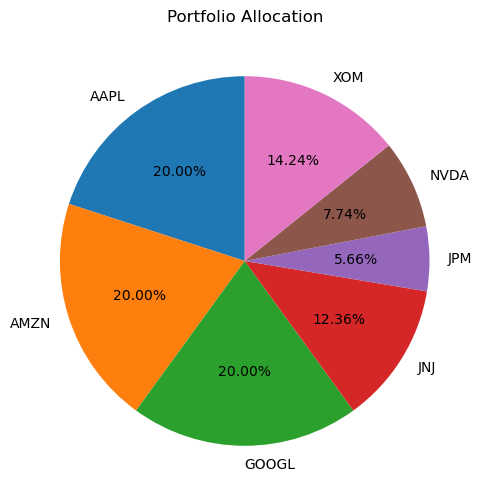

In [31]:
weights_series = pd.Series(weights)
# Filter out zero weights for cleaner visualization
weights_series = weights_series[weights_series > 0]

plt.figure(figsize=(6, 6))
plt.pie(weights_series, 
        labels=weights_series.index, 
        autopct='%1.2f%%',  # Shows percentage with 2 decimal places
        startangle=90)
plt.title('Portfolio Allocation')

plt.savefig("Portfolio Allocation.jpg")

<h4>Interpretation</h4>

Model sees **AAPL, AMZN, and GOOGL** as highly attractive on a risk-adjusted basis.<br>
**NVDA** has a modest weight of *7.74%*, although my view was that the 5% better performance. NVDA has the highest volatility as well. The max quadratic utility optimization balances return against risk using my risk aversion parameter ($\delta$). So *high volatility reduces its attractiveness*.<br>
**JNJ** receives a decent allocation of *12%*. It provides diversification benefits due to low correlation with tech stocks.